# Production wire-scan data analysis
> 07.15.2021

In [1]:
import sys
import importlib
from pprint import pprint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import proplot as plot
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sys.path.append('/Users/46h/Research/code/')
from accphys.tools import utils
from accphys.tools import beam_analysis as ba 
from accphys.tools import plotting as myplt
from accphys.tools.accphys_utils import V_matrix_4x4_uncoupled
from accphys.tools.accphys_utils import Sigma_from_twiss2D
from accphys.tools import emittance_measurement as em

In [2]:
plot.rc['grid.alpha'] = 0.04
plot.rc['figure.facecolor'] = 'white'

## Load data 

### Settings 

In [3]:
rec_node_id = 'Begin_Of_RTBT1'
# rec_node_id = 'Begin_Of_RTBT2'
# rec_node_id = 'RTBT_Diag:BPM19'
# rec_node_id = 'RTBT_Diag:WS20'
# rec_node_id = 'RTBT_Diag:BLM23'

In [4]:
ws_ids = ['WS20', 'WS21', 'WS23', 'WS24']

In [23]:
exp_twiss_filename = 'data/twiss/model_twiss_{}.dat'.format(rec_node_id)
transfer_matrices_filename = 'data/transfer_matrix/old/model_transfer_mat_elems_default_{}.dat'.format(rec_node_id)

Separate harp and wire-scanner files.

In [6]:
def is_harp_file(filename):
    file = open(filename, 'r')
    for line in file:
        if 'Harp' in line:
            return True
    return False

filenames = utils.list_files('./data/ws/')
filenames_ws = [filename for filename in filenames if not is_harp_file(filename)]
filenames_harp = [filename for filename in filenames if is_harp_file(filename)]

print('Wire-scanner files')
pprint(filenames_ws)
print('')
print('Harp files')
pprint(filenames_ws)

Wire-scanner files
['./data/ws/WireAnalysisFmt-2021.07.10_20.25.04.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_18.43.08.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_17.50.50.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.12_00.16.49.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.11_22.29.46.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_18.02.33.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.02_04.14.56.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.11_23.49.31.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.12_00.08.11.pta.txt',
 './data/ws/WireAnalysisFmt-2021.07.10_20.08.22.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.11_23.30.23.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_19.34.22.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_19.47.15.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_18.23.50.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_17.34.43.pta.txt']

Harp files
['./data/ws/WireAnalysisFmt-2021.07.10_20.25.04.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_18

### Harp 

In [7]:
harp_profiles = [em.read_pta_harp(filename) for filename in filenames_harp]

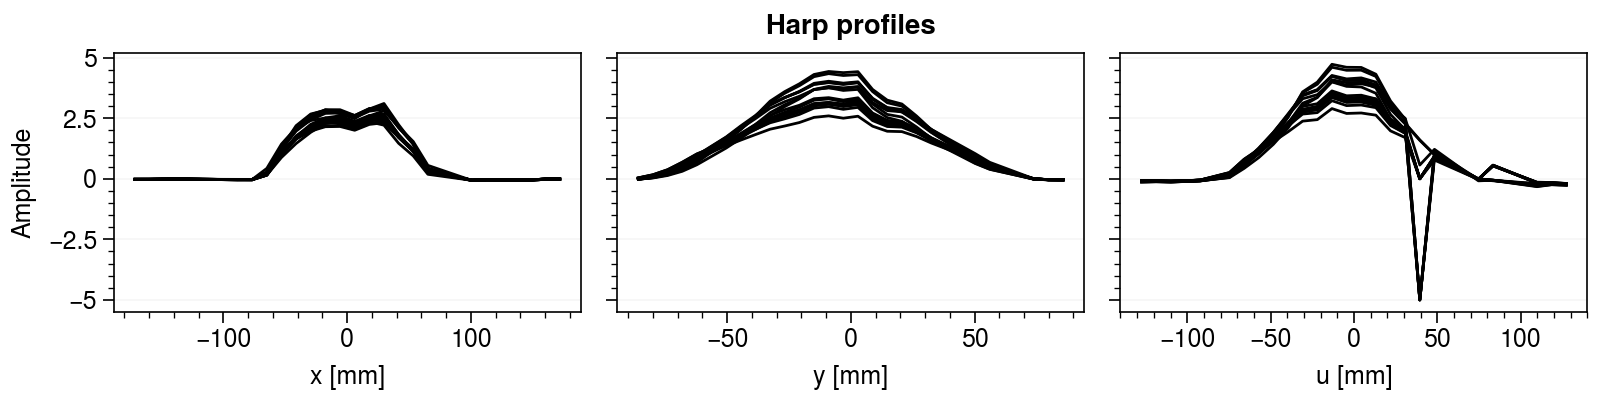

In [8]:
fig, axes = plot.subplots(ncols=3, figsize=(8, 2), spanx=False)
axes[0].set_xlabel('x [mm]')
axes[1].set_xlabel('y [mm]')
axes[2].set_xlabel('u [mm]')
axes[0].set_ylabel('Amplitude')
for profile in harp_profiles:
    signals = [profile.hor, profile.ver, profile.dia]
    for ax, signal in zip(axes, signals):
        ax.plot(signal.pos, signal.raw, marker=None, lw=1, color='k')
axes.grid(axis='x')
axes.format(suptitle='Harp profiles')

### Wire-scanners 

In [9]:
measurements = [em.read_pta_ws(filename) for filename in filenames_ws]

In [10]:
kws_raw = dict(legend=False, marker='.', ms=3, lw=0)
kws_fit = dict(legend=False, color='k', alpha=0.2, zorder=0)

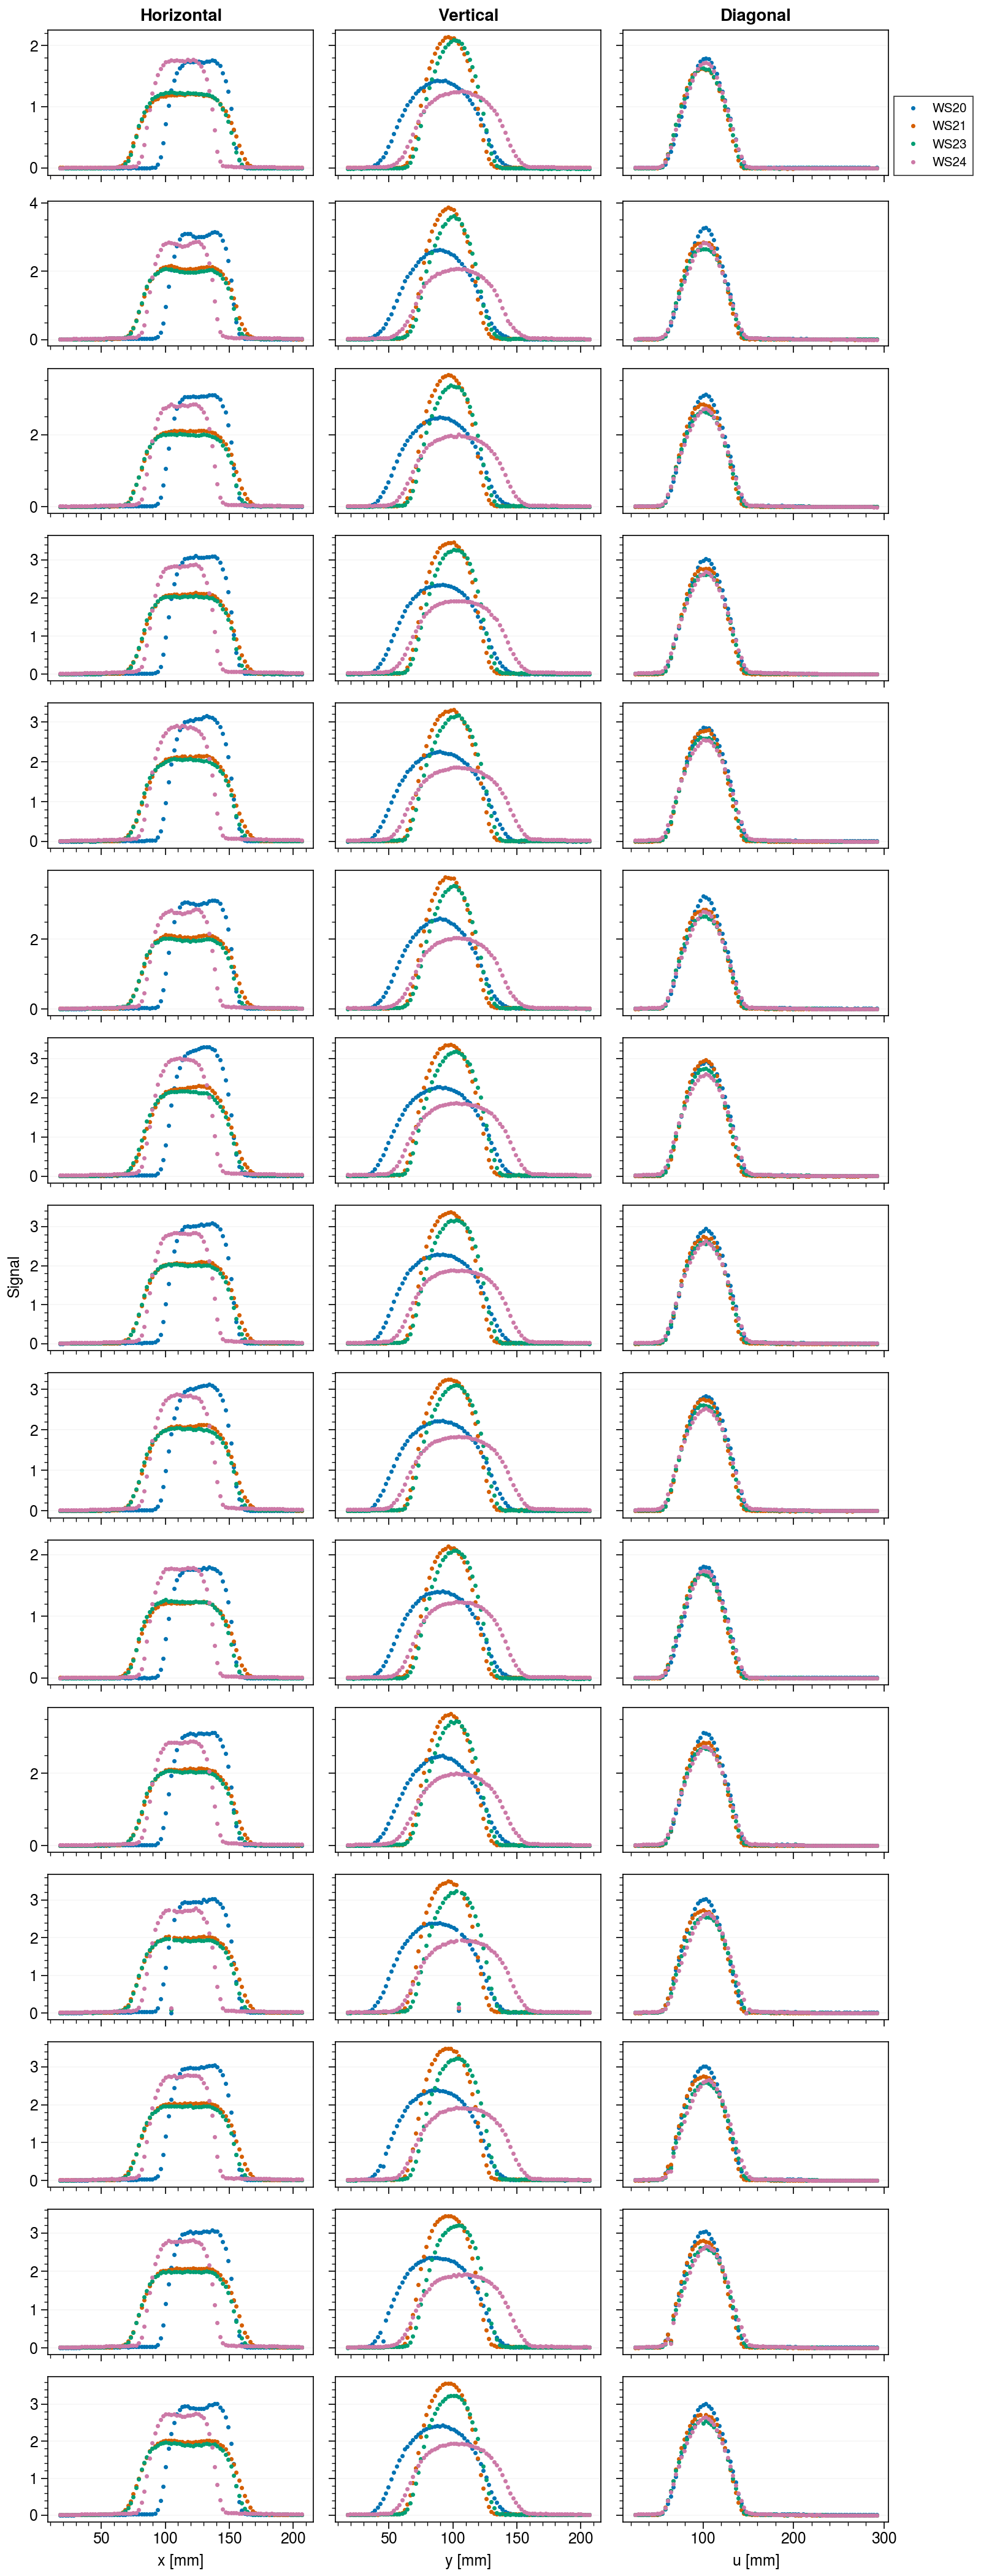

In [11]:
axes = em.plot_profiles(measurements, ws_ids, fit=False, kws_raw=kws_raw, kws_fit=kws_fit)
plt.savefig('figures/profiles.png', dpi=300, facecolor='white')

In [12]:
# axes = em.plot_profiles(measurements, ws_ids, fit=True, kws_raw=kws_raw, kws_fit=kws_fit)
# plt.savefig('figures/profiles_fit.png', dpi=300, facecolor='white')

## Reconstruct covariance matrix

Collect the measured beam moments at each wire-scanner.

In [13]:
diag_wire_angle = np.radians(-45.0)

In [14]:
moments = {ws_id: [] for ws_id in ws_ids}
for ws_id in ws_ids:
    for measurement in measurements:
        profile = measurement[ws_id]
        sig_xx = profile.hor.stats['Sigma'].rms**2
        sig_yy = profile.ver.stats['Sigma'].rms**2
        sig_uu = profile.dia.stats['Sigma'].rms**2
        sig_xy = em.get_sig_xy(sig_xx, sig_yy, sig_uu, diag_wire_angle)
        moments[ws_id].append([sig_xx, sig_yy, sig_xy])
    moments[ws_id] = np.array(moments[ws_id])

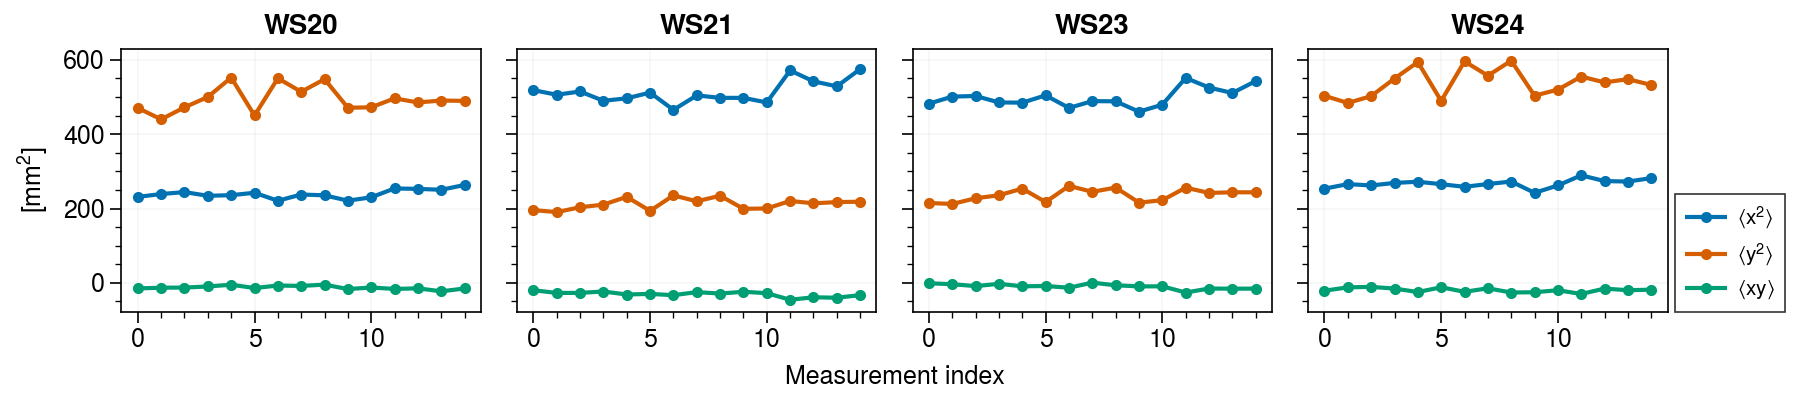

In [43]:
fig, axes = plot.subplots(ncols=4, figsize=(9, 2))
plt_kws = dict(marker='.')
for ws_id, ax in zip(ws_ids, axes):
    ax.plot(moments[ws_id][:, 0], **plt_kws)
    ax.plot(moments[ws_id][:, 1], **plt_kws)
    ax.plot(moments[ws_id][:, 2], **plt_kws)
axes.format(ylabel=r'[mm$^2$]', xlabel='Measurement index', toplabels=ws_ids)
ax.legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'],
          ncols=1, loc=(1.02, 0), fontsize='small')
plt.savefig('figures/moments.png', dpi=300, facecolor='white')

Collect the linear transfer matrices at each wire-scanner.

In [44]:
transfer_mats = {ws_id: [] for ws_id in ws_ids}
for ws_index, ws_id in enumerate(['WS02', 'WS20', 'WS21', 'WS23', 'WS24']):
    if ws_id == 'WS02': # don't have data from this wire-scanner
        continue
    for _ in range(len(measurements)):
        matrix_elements = np.loadtxt(transfer_matrices_filename)[ws_index]
        transfer_mats[ws_id].append(matrix_elements.reshape((4, 4)))

Form list from dictionaries.

In [61]:
# moments_list, transfer_mats_list = [], []
# for ws_id in ws_ids:
#     moments_list.extend(moments[ws_id])
#     transfer_mats_list.extend(transfer_mats[ws_id])

In [87]:
moments_list, transfer_mats_list = [], []
for ws_id in ws_ids:
    moments_list.extend(moments[ws_id])
    transfer_mats_list.extend(transfer_mats[ws_id])

Reconstruct the covariance matrix at the RTBT entrance.

In [225]:
np.savetxt('A.dat', A)
np.savetxt('b.dat', b)

In [227]:
from scipy import optimize as opt

A, b = [], []
for M, (sig_xx, sig_yy, sig_xy) in zip(transfer_mats_list, moments_list):
    A.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
    A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3], 0, 0, 0, 0])
    A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
    b.append(sig_xx)
    b.append(sig_yy)
    b.append(sig_xy)
A, b = np.array(A), np.array(b)

# Solve with scipy.optimize.lsq_linear
lb = 10 * [-np.inf]
lb[0] = lb[1] = lb[3] = lb[4] = 0.0 # Squared moments can't be negative
ub = 10 * [+np.inf]
result = opt.lsq_linear(A, b, bounds=(lb, ub), lsq_solver='lsmr', verbose=2)
reconstructed_moments = result.x

## Solve with numpy linear least squares
# reconstructed_moments, res, rank, s = np.linalg.lstsq(A, b, rcond=None)

# ## Solve with nonlinear least squares
# def cost(x):
#     return np.linalg.norm((np.matmul(A, x) - b)**2)
# lb = -np.inf
# ub = +np.inf
# result = opt.least_squares(cost, np.zeros(10), bounds=(lb, ub), max_nfev=10000, verbose=1)
# reconstructed_moments = result.x

Sigma = em.to_mat(reconstructed_moments)

The unconstrained solution is optimal.
Final cost 4.6022e+04, first-order optimality 4.81e+00


In [228]:
# Sigma = em.reconstruct(transfer_mats_list, moments_list)

## Analysis 

In [229]:
alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = ba.get_twiss2D(Sigma)
eps_1, eps_2 = ba.intrinsic_emittances(Sigma)

print('Sigma:')
print(Sigma)
print('eps_4D = {:.3f}'.format(np.sqrt(np.linalg.det(Sigma))))
print('eps_1, eps_2 = {:.3f}, {:.3f}'.format(eps_1, eps_2))
print('eps_x, eps_y = {:.3f}, {:.3f}'.format(eps_x, eps_y))
print('alpha_x, alpha_y = {:.3f}, {:.3f}'.format(alpha_x, alpha_y))
print('beta_x, beta_y = {:.3f}, {:.3f}'.format(beta_x, beta_y))

Sigma:
[[198.48982125  40.71152747  -0.60151715  -1.83970023]
 [ 40.71152747  14.34247807   1.40170303  -0.45116842]
 [ -0.60151715   1.40170303 317.92059654 -23.96447528]
 [ -1.83970023  -0.45116842 -23.96447528   4.95116201]]
eps_4D = 1086.655
eps_1, eps_2 = 35.369, 30.724
eps_x, eps_y = 34.488, 31.619
alpha_x, alpha_y = -1.180, 0.758
beta_x, beta_y = 5.755, 10.055


In [230]:
correlation_matrix = utils.cov2corr(Sigma)
print(correlation_matrix)

[[ 1.          0.76302045 -0.00239453 -0.05868463]
 [ 0.76302045  1.          0.02075796 -0.05353934]
 [-0.00239453  0.02075796  1.         -0.60402515]
 [-0.05868463 -0.05353934 -0.60402515  1.        ]]


In [231]:
coupling_coeff = 1.0 - np.sqrt((eps_1 * eps_2) / (eps_x * eps_y))
print('Coupling coefficient = {}'.format(coupling_coeff))

Coupling coefficient = 0.0017551715976841242


Below are the rms ellipses defined by the covariance matrix. The cross-plane projections are squares in reality.

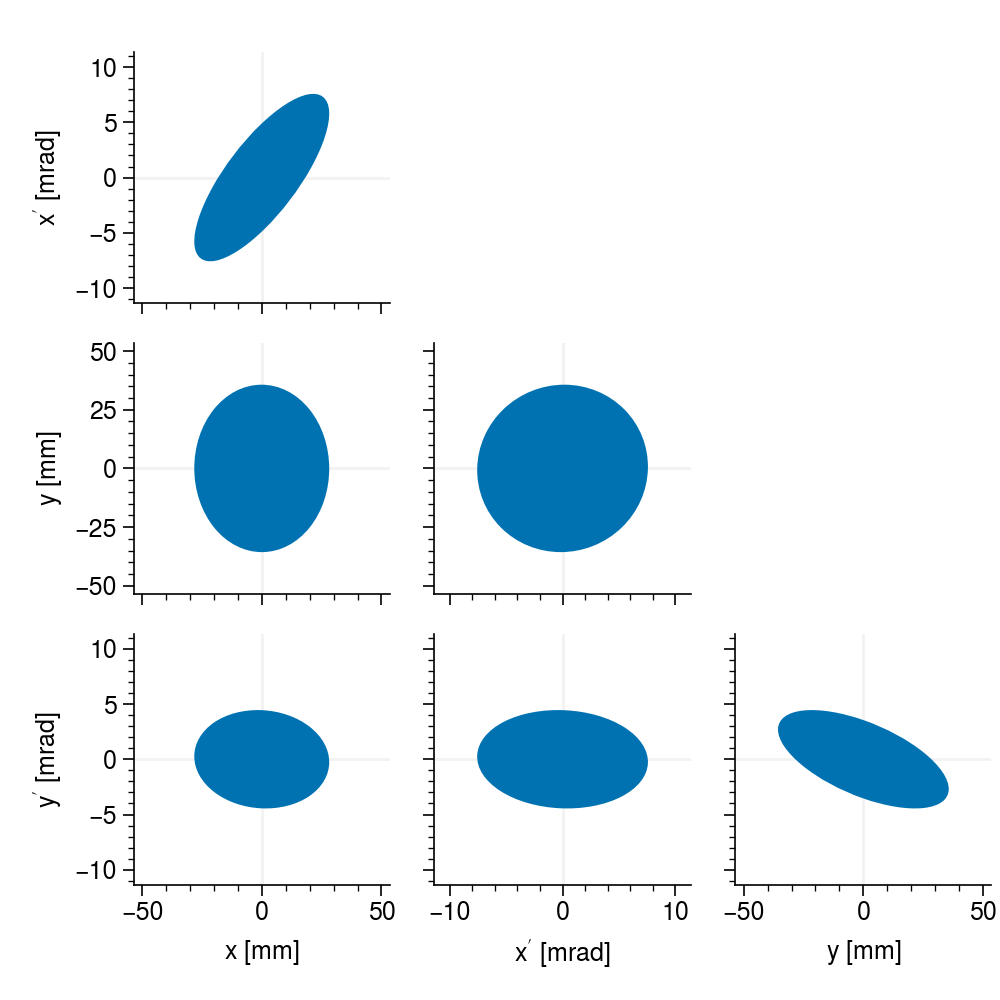

In [232]:
axes = myplt.rms_ellipses(Sigma, fill=True)
for i in range(3):
    for j in range(i + 1):
        kws = dict(lw=1, alpha=0.05, color='k', zorder=0)
        ax = axes[i, j]
        ax.axvline(0, **kws)
        ax.axhline(0, **kws)
        ax.grid(False)
plt.savefig('figures/rms_ellipses.png', dpi=300, facecolor='white');

Expected covariance matrix at RTBT entrance (from default optics).

In [233]:
twiss_exp = np.loadtxt(exp_twiss_filename)
alpha_x_exp, alpha_y_exp, beta_x_exp, beta_y_exp = twiss_exp
print('alpha_x_exp, alpha_y_exp = {:.3f}, {:.3f}'.format(alpha_x_exp, alpha_y_exp))
print('beta_x_exp, beta_y_exp = {:.3f}, {:.3f}'.format(beta_x_exp, beta_y_exp))
Sigma_exp = Sigma_from_twiss2D(alpha_x_exp, alpha_y_exp, beta_x_exp, beta_y_exp, eps_x, eps_y)

alpha_x_exp, alpha_y_exp = -1.226, 0.765
beta_x_exp, beta_y_exp = 5.656, 9.869


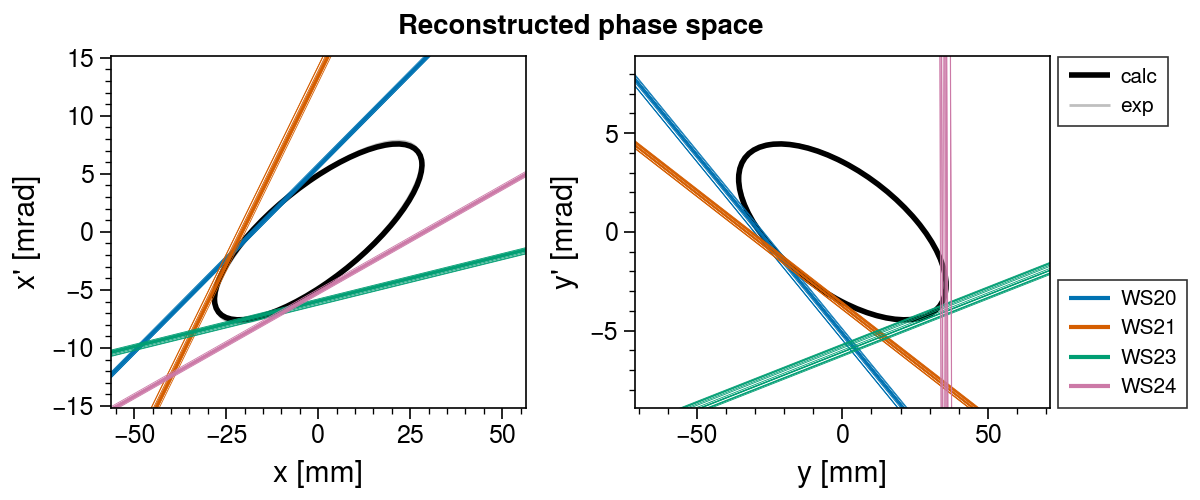

In [234]:
axes = em.plot_reconstructed_phasespace(transfer_mats, moments, Sigma, Sigma_exp)
axes.format(suptitle='Reconstructed phase space')
plt.savefig('figures/lines.png', dpi=300, facecolor='white')

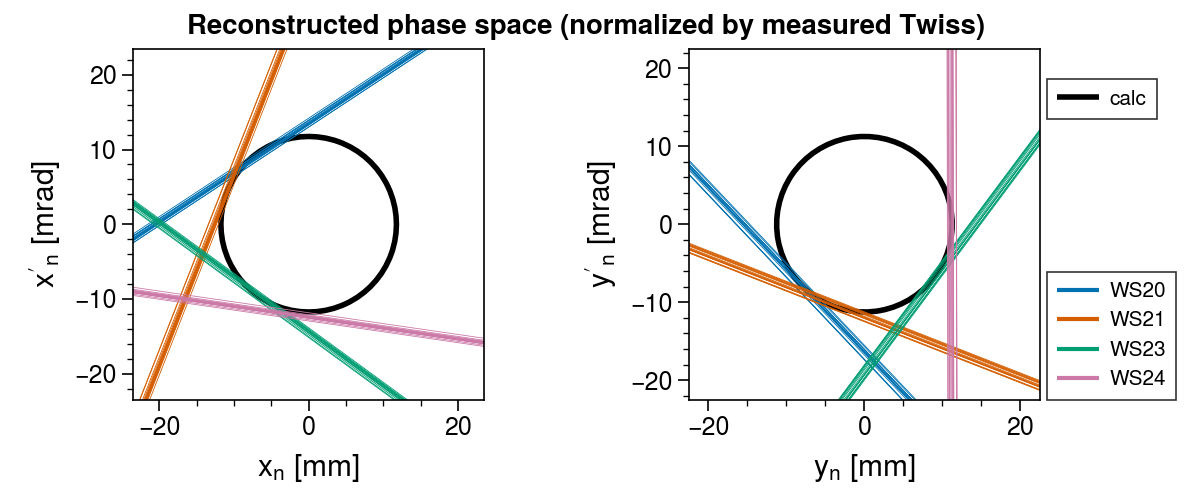

In [235]:
axes = em.plot_reconstructed_phasespace(transfer_mats, moments, 
                                        Sigma, Sigma_exp=None, 
                                        twiss=(alpha_x, alpha_y, beta_x, beta_y))
axes.format(suptitle='Reconstructed phase space (normalized by measured Twiss)')
plt.savefig('figures/lines_norm.png', dpi=300, facecolor='white')